In [63]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [51]:
df = pd.read_csv("data/insurance.csv")

In [52]:
# Binary encoding smoker 
df['smoker'] = df['smoker'].map({'yes':1, 'no':0})

In [53]:
# Combining bmi and smoker since linear regression assumes additive effects of features, but the effect of BMI depends on whether someone smokes
df['bmi_smoker'] = df['bmi'] * df['smoker'] 

In [54]:
# Splitting into X and y
X = df.drop("charges", axis=1)
y = df['charges']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [56]:
# Applying log transformation to charges as they are right skewed. Helps to make distribution more normal which helps linear models converge faster
y_train_log = np.log(y_train)

In [57]:
cat_cols = ['sex', 'region']
# Including smoker as it has been encoded
num_cols = ['age', 'bmi', 'children', 'smoker', 'bmi_smoker']

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Combining using Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Build model pipelines
linreg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])
ridge_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Ridge())
])
lasso_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Lasso())
])
dectree_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', DecisionTreeRegressor())
])
randfor_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor())
])
gradboost_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', GradientBoostingRegressor())
])



In [58]:
models = {
    "Linear Regression": linreg_pipeline,
    "Ridge": ridge_pipeline,
    "Lasso": lasso_pipeline,
    "Decision Tree Regressor": dectree_pipeline,
    "Random Forest Regressor": randfor_pipeline,
    "Gradient Boosting Regressor": gradboost_pipeline
}

for name, model in models.items():
    # Fit the model (running the pipeline)
    model.fit(X_train, y_train_log)
    
    # Predict on test set. Exponentiating the prediction (Y_test) since it was trained on logarithmic charges.
    y_pred = np.exp(model.predict(X_test))

    # Evaluate metrics (r2 measures proportion of variance in model, higher is better. mae measures absolute difference, lower is better. rmse 
    # measures sqrt of the avg sqrd differences, lower is better)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{name}: R2={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

Linear Regression: R2=0.528, MAE=3974.99, RMSE=8561.67
Ridge: R2=0.536, MAE=3956.33, RMSE=8484.28
Lasso: R2=-0.098, MAE=8603.14, RMSE=13053.87
Decision Tree Regressor: R2=0.775, MAE=2664.62, RMSE=5912.02
Random Forest Regressor: R2=0.871, MAE=2067.57, RMSE=4478.62
Gradient Boosting Regressor: R2=0.873, MAE=2024.27, RMSE=4441.57


It can be seen from the metrics that Random Forest Regressor and Gradient Boosting Regressors are the best models. MAE ~ 2000 for tree models means average error is $2k, which is reasonable for insurance costs.

In [60]:
# Running winning model 
randfor_pipeline.fit(X_train, y_train_log)
y_pred = np.exp(randfor_pipeline.predict(X_test))
score = r2_score(y_test, y_pred)*100
print("Accuracy of model is %.2f" %score)

Accuracy of model is 87.07


Text(0, 0.5, 'Predicted')

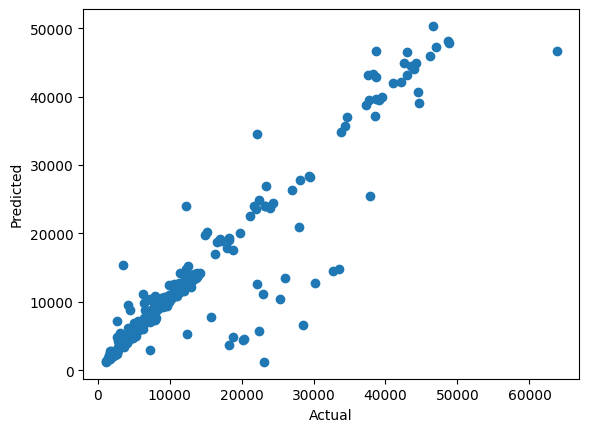

In [64]:
# Plotting model accuracy
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")


It can be seen in the graph that there is a strong linear correlation between the actual and predicted values with minimal outliers, reflecting the 87.07% accuracy of the model.

In [65]:
# Testing a completely new point not in the dataset
new_point = pd.DataFrame({
    'age': [50],
    'bmi': [30.2],
    'children': [3],
    'smoker': [0],
    'bmi_smoker': [30.2 * 0],
    'sex': ['male'],
    'region': ['northwest']
})

prediction = randfor_pipeline.predict(new_point)
final_prediction = np.exp(prediction)

score = r2_score(y_test, y_pred)*100

print("Predicted charges:", final_prediction[0])


Predicted charges: 10959.102299281198
